<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> IFTA: Algoritmo adaptativo </font>
</div>

- **Para**: IFTA

- **Fecha**: 2021/11/12
        
- **Autores**: 
    - Luis Miguel Sánchez Brea
    - Ángela Soria García
   

- **Objetivos**: Desarrollar el algoritmo IFTA en campo lejano y cercano con la binarización incorporada y eliminando la parte de amplitud / fase. 

- **Descripción** El Algoritmo IFTA que tenemos implementado es directamente el algoritmo continuo de fase, y luego binarizamos y/o pasamos a amplitud. Aquí lo que hacemos es implementar las restricciones en el propio proceso.

- **Referencias**: 
    -R. W. Gerchberg and W. O. Saxton, “A Practical Algorithm for the Determination of Phase from Image and Diffraction Plane Pictures,” Optik (Stuttg)., vol. 35, no. 2, pp. 237–246, 1972. 

# Código

In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_drawing import draw_several_fields

from py_aocg.ifta.algorithms import GS_scalar_Fresnel
from py_aocg.ifta.parameters import mean_square_error, mnse, verify_mask, compute_error, make_binary

## Función desarrollada

In [3]:
def GS_Fresnel_algorithm_new(source, target, z, kind, is_binary, num_steps, phase=np.pi, has_draw=False):
    """
    # kin(str): 'amplitude' or 'phase'
    is_binary (bool): 
    """

    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    wavelength = target.wavelength
    num_x = len(x)
    num_y = len(y)
    

    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    field_z = Scalar_mask_XY(x, y, wavelength)

    u_target = np.abs(target.u)
    I_result = np.abs(target.u)**2
    I_result_mean = I_result.mean()

    field_z.u = u_target * np.exp(2j * phase * np.random.rand(num_y, num_x))

    for i in range(num_steps):
        DOE = field_z.RS(z=-z, new_field=True)
        quality = DOE.quality
            
        if kind == 'amplitude':
            mask = np.abs(DOE.u)
            if is_binary:
                mask=make_binary(mask, 0, 1, 0.5)
                
            DOE.u=mask
            

        elif kind=='phase':
            mask = np.angle(DOE.u)
            if is_binary:
                mask=make_binary(mask, -np.pi/2, np.pi/2, 0)
                
            DOE.u = np.exp(1j * mask)       
        
        field_z = (source * DOE).RS(z=z, new_field=True)
        #field_z.draw()
        I_z = np.abs(field_z.u)**2
        #I_z = I_z * I_result_mean / I_z.mean()
        I_z = I_z  / I_z.max()
        #print("I_z=",I_z.max(),end='r/')

        field_z.u = u_target * np.exp(1j * np.angle(field_z.u))

        # if has_mask:
        #     DOE.u=np.exp(1j*np.pi*mask)*circle.u

        error = mean_square_error(I_result, I_z)
        #print("I_result=",I_result.max())
       
        print("{}/{} - error {:2.6f}".format(i, num_steps,  error), end='\r')
        errors[i] = error

    if kind == 'phase':
        mask = (mask + np.pi) / (2 * np.pi)
        mask = mask * target.u
        

    if has_draw:
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    return DOE, mask_final, errors

## Mask a

In [72]:
num_x=256
num_y=256
DOE_size=40*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um
num_steps = 100
lamda = np.linspace(1,0,num_steps)


In [73]:
source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()

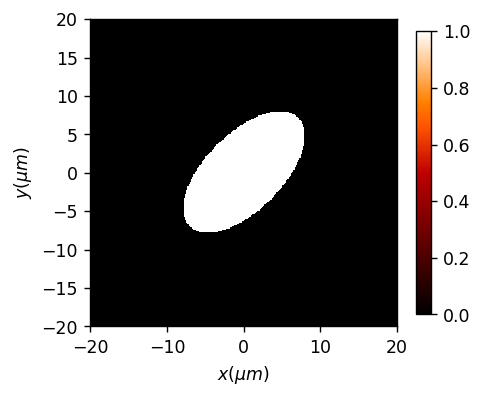

In [74]:
target=Scalar_mask_XY(x,y,wavelength)
target.circle(r0=(0,0), radius=(10,5), angle=45*degrees)
target.draw(has_colorbar='vertical');

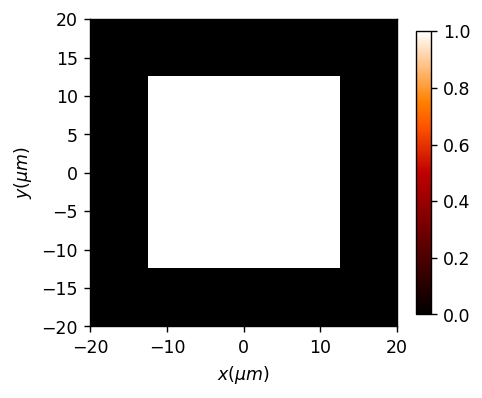

In [86]:
w=Scalar_mask_XY(x,y,wavelength)
w.square(r0=(0,0), size=(25,25), angle=0)
w.draw(has_colorbar='vertical');

In [87]:
kind = 'phase'
z=15*um
phase = np.pi
is_binary = False
has_draw = 'False'

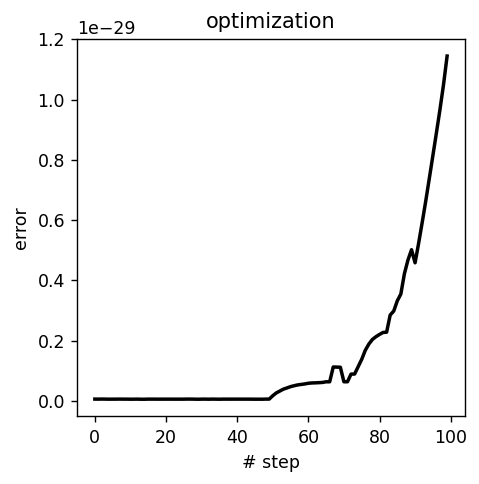

In [88]:
errors = np.zeros(num_steps)

x = target.x
y = target.y
wavelength = target.wavelength
num_x = len(x)
num_y = len(y)
    

DOE = Scalar_mask_XY(x, y, wavelength)
field_z = Scalar_mask_XY(x, y, wavelength)
field_ant = Scalar_mask_XY(x,y,wavelength)
i_target = (w.u>0)

u_target = np.abs(target.u)
I_result = np.abs(target.u)**2

field_z.u = u_target * np.exp(2j * phase * np.random.rand(num_y, num_x))


for i in range(num_steps):
    DOE = field_z.RS(z=-z, new_field=True)
    #quality = DOE.quality
   
    field_ant.u = np.abs(field_z.u)

    if kind == 'amplitude':
        mask = np.abs(DOE.u)
        if is_binary:
            mask=make_binary(mask, 0, 1, 0.5)

        DOE.u=mask


    elif kind=='phase':
        mask = np.angle(DOE.u)
        if is_binary:
            mask=make_binary(mask, -np.pi/2, np.pi/2, 0)

        DOE.u = np.exp(1j * mask)       

    field_z = (source * DOE).RS(z=z, new_field=True)

    #plt.figure()
    #plt.imshow(np.abs(field_z.u))
    #I_z = I_z  / I_z.max()
    #print("I_z=",I_z.max(),end='r/')
    #field_z.u[i_target] = (((1-lamda[i])*u_target[i_target] + lamda[i]*field_ant.u[i_target]))*np.exp(1j * np.angle(field_z.u[i_target]))
    field_z.u[i_target] = ((lamda[i]*u_target[i_target] + (1-lamda[i])*field_ant.u[i_target]))*np.exp(1j * np.angle(field_z.u[i_target]))
    
    I_z = np.abs(field_z.u)**2
    mean_factor = I_z[u_target>0].mean()
    I_z = I_z / mean_factor
    # if has_mask:
    #     DOE.u=np.exp(1j*np.pi*mask)*circle.u

    error = mean_square_error(I_result[i_target],I_z[i_target])
  
    print("{}/{} - error {}".format(i, num_steps,error), end='\r')
    errors[i] = error


if kind == 'phase':
    mask = (mask + np.pi) / (2 * np.pi)
    mask = mask * target.u
    
    

if has_draw:
    plt.figure()
    plt.plot(errors, 'k', lw=2)
    plt.xlabel('# step')
    plt.ylabel('error')
    plt.title('optimization')
    #plt.ylim(ymin=0)



mask_final = Scalar_mask_XY(x, y, wavelength)
mask_final.u = mask

In [89]:
mask_final.draw('field');

In [90]:
DOE.draw('field')

((<matplotlib.image.AxesImage at 0x1f7c677b790>,
  <matplotlib.image.AxesImage at 0x1f7c25e5f70>),
 None,
 None)

Good result: factor 3.22


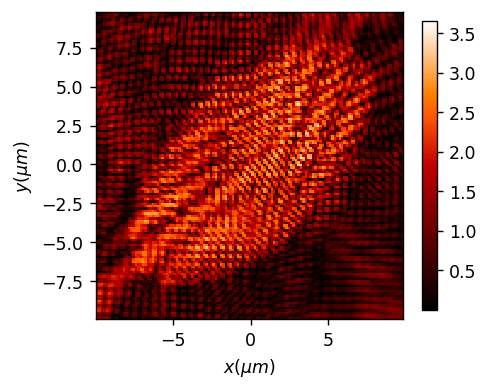

In [91]:
u_adaptativo = DOE.RS(z, verbose=True)
u_near=u_adaptativo.cut_resample([-10,10], [-10,10], new_field=True)
u_adaptativo.draw(has_colorbar='vertical', logarithm=1e-0);
u_near.draw(has_colorbar='vertical', logarithm=10);

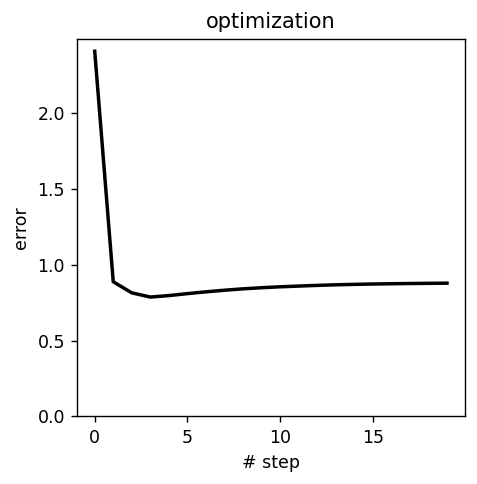

In [20]:
num_steps=20
z_distance = z
DOE_new, mask_final, errors = GS_Fresnel_algorithm_new(None,target, z=z_distance, num_steps=num_steps, kind='amplitude', is_binary=False, has_draw=True)

In [21]:
DOE_new.draw('field');

In [22]:
u_ifta = DOE_new.RS(z=z_distance, verbose=True)
u_ifta.draw(has_colorbar='vertical');

Good result: factor 3.22


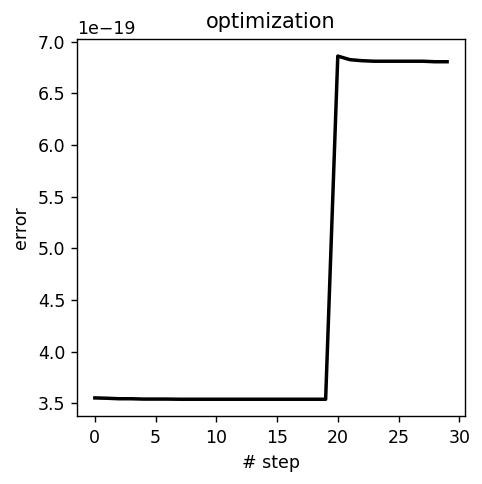

In [40]:
num_steps=30


errors = np.zeros(num_steps)

x = target.x
y = target.y
wavelength = target.wavelength
num_x = len(x)
num_y = len(y)
    

DOE = Scalar_mask_XY(x, y, wavelength)
field_z = Scalar_mask_XY(x, y, wavelength)
field_ant = Scalar_mask_XY(x,y,wavelength)
i_target = (w.u>0)

u_target = np.fft.fftshift(np.abs(target.u))
I_result = u_target**2

field_z.u = u_target * np.exp(2j * phase * np.random.rand(num_y, num_x))


for i in range(num_steps):
    DOEu = field_z.ifft(shift=False, matrix=True, new_field=False)
    #quality = DOE.quality
    field_ant.u = np.abs(field_z.u)
    

    if kind == 'amplitude':
        mask = np.abs(DOEu)
        if is_binary:
            mask=make_binary(mask, 0, 1, 0.5)

        DOEu=mask


    elif kind=='phase':
        mask = np.angle(DOEu)
        if is_binary:
            mask=make_binary(mask, -np.pi/2, np.pi/2, 0)

        DOEu = np.exp(1j * mask)   
        
    DOE.u = DOEu
    fieldz = (source * DOE).fft(shift=False, matrix=True)
    fieldz = fieldz/fieldz.max()
    fieldz = field_z.u
   
    

    #plt.figure()
    #plt.imshow(np.abs(field_z.u))
    #I_z = I_z  / I_z.max()
    #print("I_z=",I_z.max(),end='r/')
   
    field_z.u[i_target] = ((lamda[i]*u_target[i_target] + (1-lamda[i])*field_ant.u[i_target]))*np.exp(1j * np.angle(field_z.u[i_target]))
    
    I_z = np.abs(field_z.u)**2
    mean_factor = I_z[u_target>0].mean()
    I_z = I_z / mean_factor
    # if has_mask:
    #     DOE.u=np.exp(1j*np.pi*mask)*circle.u

    error = mnse(I_result[i_target],I_z[i_target])
  
    print("{}/{} - error {}".format(i, num_steps,error), end='\r')
    errors[i] = error


if kind == 'phase':
    mask = (mask + np.pi) / (2 * np.pi)
    mask = mask * target.u
    
    

if has_draw:
    plt.figure()
    plt.plot(errors, 'k', lw=2)
    plt.xlabel('# step')
    plt.ylabel('error')
    plt.title('optimization')
    #plt.ylim(ymin=0)



mask_final = Scalar_mask_XY(x, y, wavelength)
mask_final.u = mask

In [41]:
mask_final.draw('field');

In [42]:
DOE.draw('field')

((<matplotlib.image.AxesImage at 0x1f7bed64670>,
  <matplotlib.image.AxesImage at 0x1f7c2240c10>),
 None,
 None)

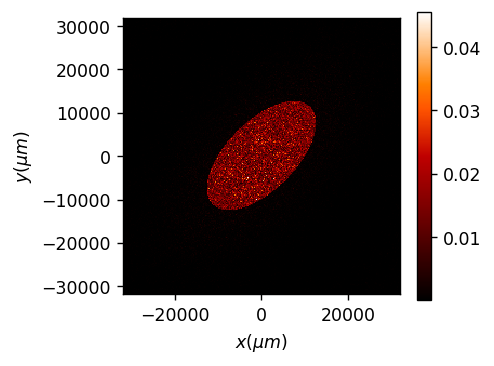

In [43]:
u_far = DOE.fft(new_field=True, shift=True, remove0=False)
u_far.draw(has_colorbar='vertical');

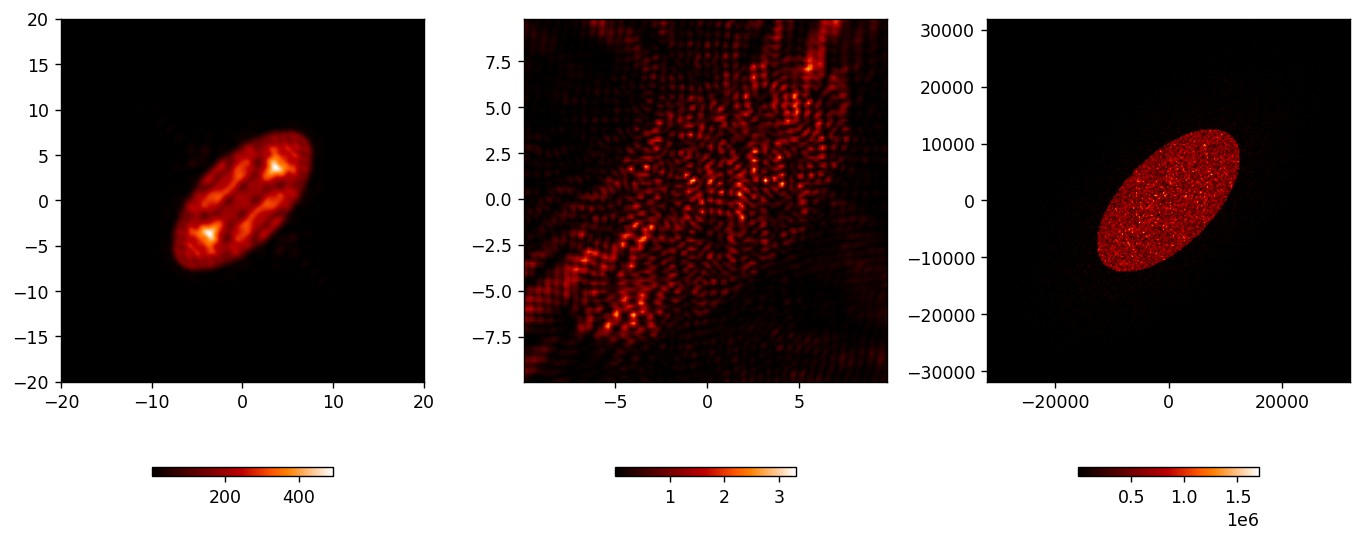

In [27]:
draw_several_fields((u_ifta,u_near,u_far))
plt.tight_layout()